In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
import scipy.io
import os
npr.seed(0)
from ipywidgets import widgets
from src.utils import pathsetup

import ssm
import smartload.smartload as smart
from ssm.util import find_permutation, split_by_trials
from ssm.plots import gradient_cmap, white_to_color_cmap
from ssm.exputils import load_multiple_sessions, load_session, make_savedict, run_and_save, get_id_range, sigmoid
npr.seed(0)

import matplotlib.pyplot as plt
import src.blockhmm_validation as bval

%matplotlib notebook

# Speficy whether or not to save figures
save_figures = True

%reload_ext autoreload
%autoreload 2

In [2]:
# Set the parameters of the HMM
time_bins = 1000   # number of time bins
num_states = 3    # number of discrete states
obs_dim = 30       # dimensionality of observation

# Make an HMM
gen_seed = 125
np.random.seed(gen_seed)
true_hmm = ssm.HMM(num_states, obs_dim, observations="blocklapse")

true_hmm.observations.mus = np.array([1, 9, 4]).T
true_hmm.observations.sigmas = np.array([0.8, 1.5, 0.2]).T
true_hmm.observations.lapses = np.array([0.15, 0.05, 0.3]).T

# true_hmm.transitions.transition_matrix = np.array([[0.98692759, 0.01307241],
#                                        [0.00685383, 0.99314617]])


# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

arr=  true_hmm.observations.log_likelihoods(obs, None, None, None)

true_ll = true_hmm.log_probability(obs)

<IPython.core.display.Javascript object>


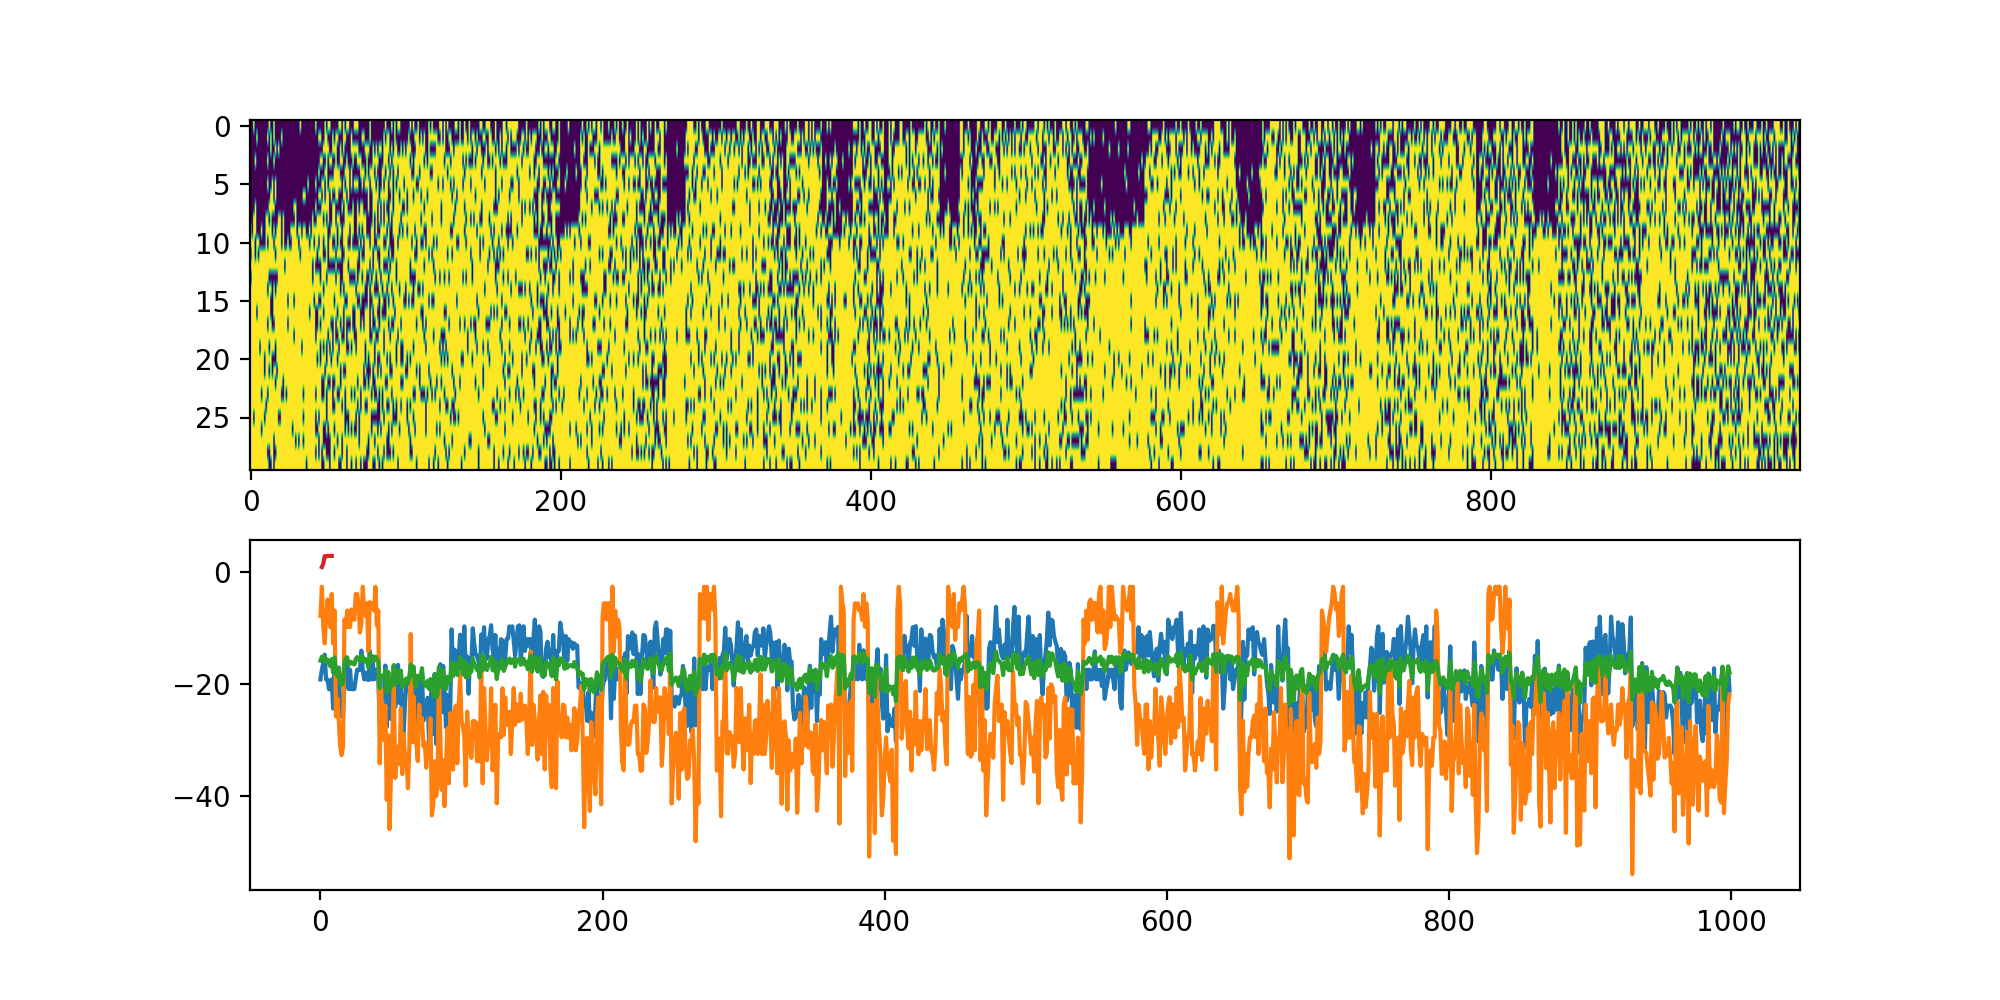

In [3]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.imshow(obs.T, aspect='auto')
plt.subplot(212)
plt.plot(arr)

  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


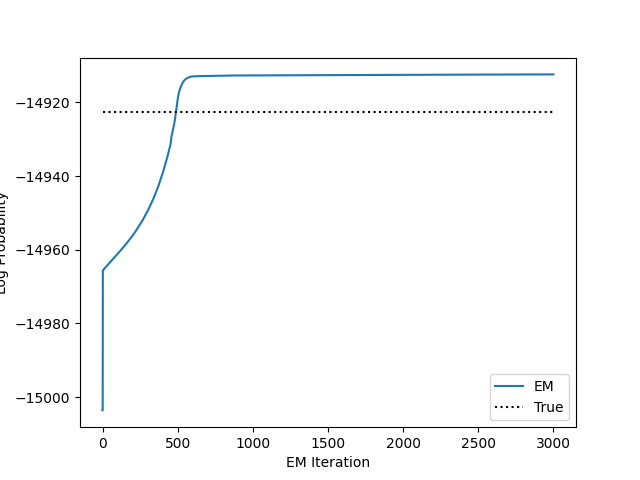

In [10]:
data = obs # Treat observations generated above as synthetic data.
N_iters = 3000

fitseed = 126
np.random.seed(fitseed)

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="blocklapse")

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")

plt.figure()
plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

<IPython.core.display.Javascript object>


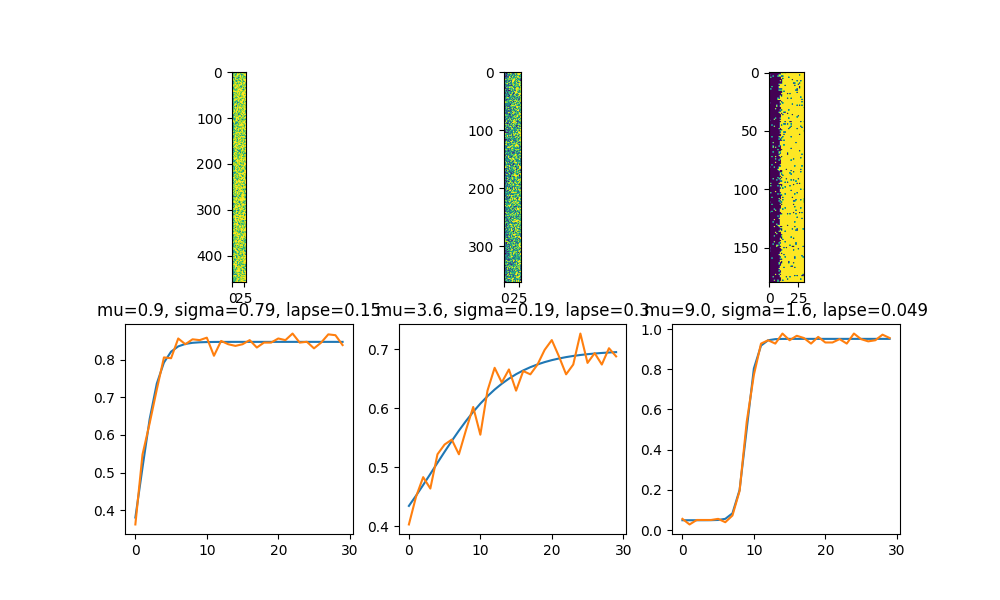

In [11]:
def sigmoid(x, mu, sigma, lapse=0):
    return lapse + (1-2*lapse) / (1 + np.exp(-(x - mu) * sigma))

# hmm.permute([1,3,0,2])

# Pool states and visualize
zstates = hmm.most_likely_states(obs)
obs_clustered = list(map(lambda x: obs[(zstates == x),:], np.unique(zstates)))

# Construct the block transition function for each mode
mus, sigmas, lapses = hmm.observations.params

transfuncs = list(map(lambda mu,sigma, lapse: sigmoid(np.arange(hmm.D), mu, sigma, lapse), mus, sigmas, lapses))
plt.figure(figsize=(10,6))

for i in range(num_states):
    plt.subplot(2,num_states,i+1)
    plt.imshow(obs_clustered[i])
    
    plt.subplot(2, num_states, i+1+num_states)
    plt.plot(transfuncs[i])
    plt.plot(np.nanmean(obs_clustered[i], axis=0))
    
    plt.title(f'mu={mus[i][0]:.2}, sigma={sigmas[i][0]:.2}, lapse={lapses[i][0]:.2}')
    


<IPython.core.display.Javascript object>


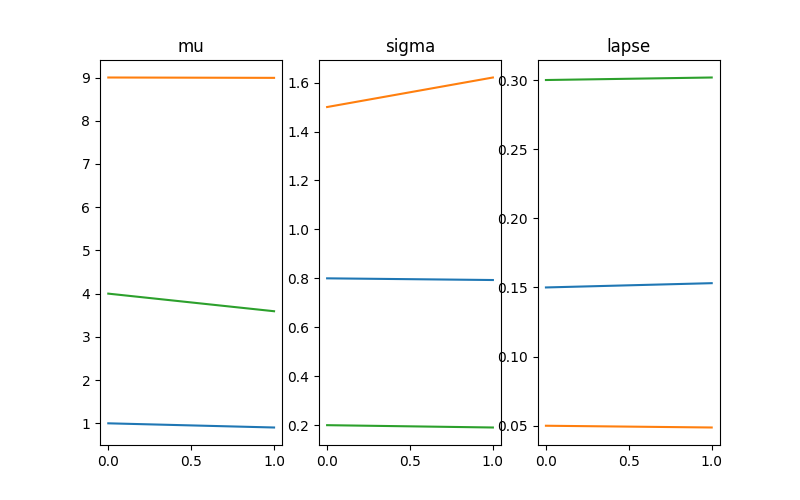

In [12]:
most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))

# Comparing the true and inferred parameters
true_params = np.squeeze(np.array(true_hmm.observations.params))
sim_params = np.squeeze(np.array(hmm.observations.params))

titles = ['mu', 'sigma', 'lapse']
nparams = true_params.shape[0]
plt.figure(figsize=(8,5))
for j in range(nparams):
    plt.subplot(1,nparams,j+1)
    for i in range(hmm.K):
        plt.plot([true_params[j,i], sim_params[j,i]])
        plt.title(titles[j])
    
    

<IPython.core.display.Javascript object>


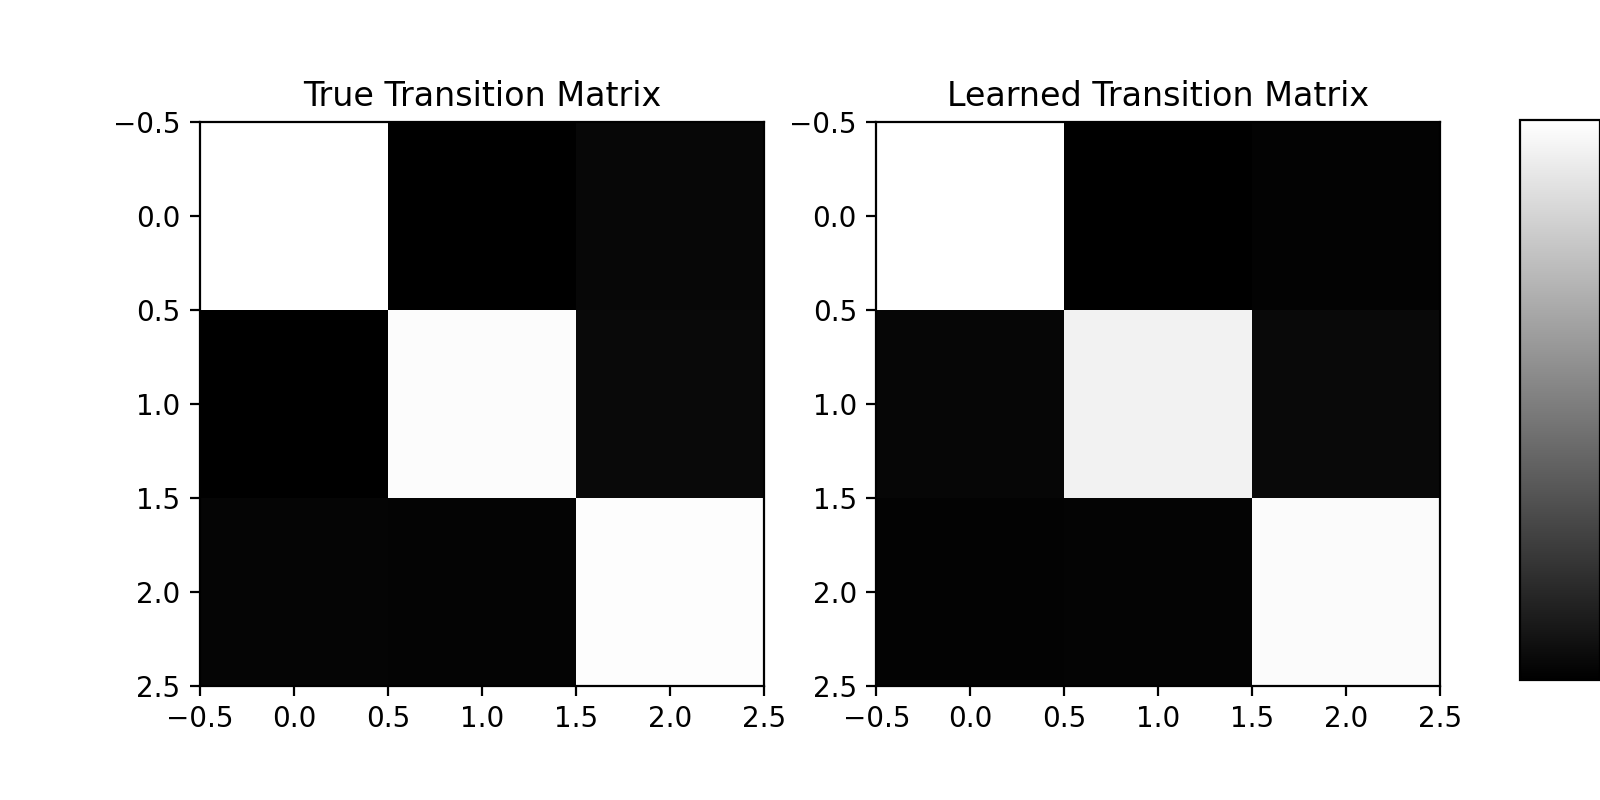

In [7]:
# Note: rows correspond to origin state, columns are destinations
# so that (i,j) entry corresponds to P(z_t+1 = j | z_t = i)
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


In [8]:
# Save the data
paths = pathsetup('matchingsim')
savename = f"{paths['blockhmmsimdata']}/blockhmm_simulated_122921.mat"
if not os.path.exists(savename):
    scipy.io.savemat(savename, dict(true_transition_mat=true_transition_mat, learned_transition_mat=learned_transition_mat,
                                   true_params=true_params, sim_params=sim_params, most_likely_states=most_likely_states,
                                   time_bins=time_bins, num_states=num_states, obs_dim=obs_dim, 
                                   true_mus=true_hmm.observations.mus, true_sigmas=true_hmm.observations.sigmas,
                                   true_lapses=true_hmm.observations.lapses, true_states=true_states, obs=obs,
                                   true_ll=true_ll, gen_seed=gen_seed, fitseed=fitseed, N_iters=N_iters,
                                   hmm_lls=hmm_lls, zstates=zstates, obs_clustered=obs_clustered, transfuncs=transfuncs))
else:
    print('File exists, skipping save...')

/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/scipy/io/matlab/mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


## Validating the number of clusters, $K$

In [4]:
nstates_lst = np.arange(1, 9)
N_iters = 3000
frac_train = 0.8

ll_lst, nstates_lst, obs_train, obs_test = bval.run_and_validate_synthetic(obs, seed=123, params=dict(nstates_lst=nstates_lst,
                                                                                                 N_iters=N_iters, frac_train=frac_train))

  0%|          | 0/3000 [00:00<?, ?it/s]

Num states = 1, likelihood = 0.8288570003880934


  0%|          | 0/3000 [00:00<?, ?it/s]

Num states = 2, likelihood = 1.4088441103471288


  0%|          | 0/3000 [00:00<?, ?it/s]

/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


Num states = 3, likelihood = 2.7787575237735567


  0%|          | 0/3000 [00:00<?, ?it/s]

Num states = 4, likelihood = 2.7417320875434172


  0%|          | 0/3000 [00:00<?, ?it/s]

Num states = 5, likelihood = 2.810980330813117


  0%|          | 0/3000 [00:00<?, ?it/s]

Num states = 6, likelihood = 2.8171168066055565


  0%|          | 0/3000 [00:00<?, ?it/s]

Num states = 7, likelihood = 2.81768661407266


  0%|          | 0/3000 [00:00<?, ?it/s]

Num states = 8, likelihood = 2.816802749455664
[1 2 3 4 5 6 7 8]
[0.8288570003880934, 1.4088441103471288, 2.7787575237735567, 2.7417320875434172, 2.810980330813117, 2.8171168066055565, 2.81768661407266, 2.816802749455664]


<IPython.core.display.Javascript object>


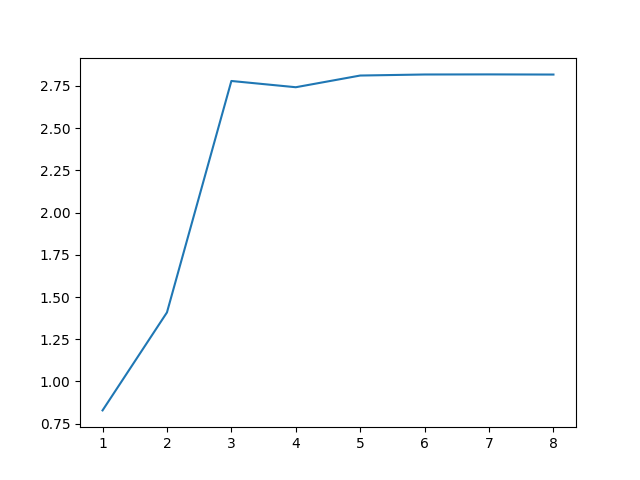

In [6]:
plt.figure()
plt.plot(nstates_lst, ll_lst)

In [7]:
# Save the data
paths = pathsetup('matchingsim')
savename = f"{paths['blockhmmsimdata']}/blockhmm_synthetic_K_validation_122921.mat"
if not os.path.exists(savename):
    scipy.io.savemat(savename, dict(obs=obs, nstates_lst=nstates_lst, N_iters=N_iters,
                                   frac_train=frac_train, ll_lst=ll_lst, obs_train=obs_train,
                                   obs_test=obs_test))
else:
    print('File exists, skipping save...')